# Original start code

In [478]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py
import numpy as np

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines , plot_color_lines

In [479]:
# Load an image
#img = cv2.imread('../assets/images/example.jpg')[:, :, ::-1]
img = cv2.imread('../assets/data/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg')[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)


net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

[[405.64166 375.96985]
 [408.58734 340.96527]]


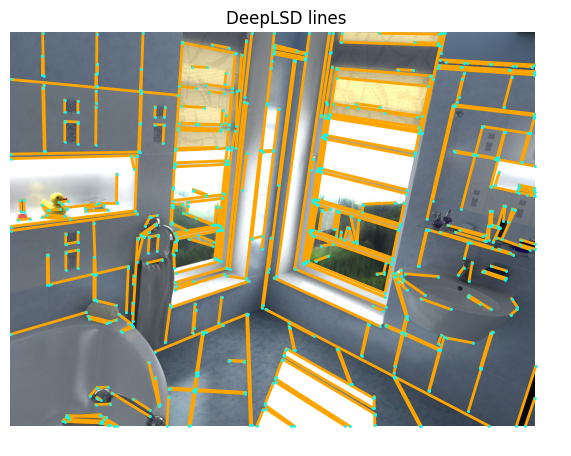

In [481]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]
    print(pred_lines[0])

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))

# Find structural lines



## Import depth and normal maps

In [1]:
import h5py
import numpy as np

# Load depth from one HDF5 file
with h5py.File("../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5", "r") as f:
    depth_map = np.array(f["dataset"])

# Load world-space normals from the second HDF5 file
with h5py.File("../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_bump_world.hdf5", "r") as f:
    normal_map = np.array(f["dataset"])  # Using world-space normals

print("Depth shape:", depth_map.shape)
print("Normal shape:", normal_map.shape)  # Should be (H, W, 3)


Depth shape: (768, 1024)
Normal shape: (768, 1024, 3)


In [ ]:
from skimage.draw import line

def get_line_points_skimage(x1, y1, x2, y2):
    """ Generate integer pixel coordinates along a line using skimage. """
    rr, cc = line(int(y1), int(x1), int(y2), int(x2))  # row (y), col (x)
    return np.column_stack((cc, rr))  # Return as (x, y) pairs

def get_line_points_linspace(x1, y1, x2, y2, num_points=100):
    """ Get evenly spaced points along a line using NumPy interpolation. """
    x = np.linspace(x1, x2, num_points)
    y = np.linspace(y1, y2, num_points)
    return np.column_stack((x.astype(int), y.astype(int)))  # Convert to (N,2) (x,y)

def extract_line_data(x1, y1, x2, y2, depth_map, normal_map):
    """ Extract depth and normal values along a given line. """
    h, w = depth_map.shape
    points = get_line_points_skimage(x1, y1, x2, y2)
    # Ensure points are within valid image bounds
    points = points[(points[:, 1] >= 0) & (points[:, 1] < h) & (points[:, 0] >= 0) & (points[:, 0] < w)]
                
    # Extract depth values along the line
    depth_values = depth_map[points[:, 1], points[:, 0]]

    # Extract normal vectors along the line
    normal_values = normal_map[points[:, 1], points[:, 0], :]

    return depth_values, normal_values

def cosine_similarity(v1, v2):
    """ Compute cosine similarity between two vectors """
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def get_neighborhood_values(x, y, depth_map, normal_map, offset=1):
    """Extract depth and normal values at (x, y) and its neighbors."""
    h, w = depth_map.shape

    # Ensure valid pixel coordinates
    x = np.clip(x, 0, w - 1)
    y = np.clip(y, 0, h - 1)

    # Define neighboring coordinates (left, right, up, down)
    neighbors = [
        (x, y),  # Center pixel
        (np.clip(x - offset, 0, w - 1), y),  # Left
        (np.clip(x + offset, 0, w - 1), y),  # Right
        (x, np.clip(y - offset, 0, h - 1)),  # Up
        (x, np.clip(y + offset, 0, h - 1))   # Down
    ]

    # Extract depth and normal values at these points
    depth_values = np.array([depth_map[int(n[1]), int(n[0])] for n in neighbors])
    normal_values = np.array([normal_map[int(n[1]), int(n[0]), :] for n in neighbors])

    return depth_values, normal_values

def compute_neighborhood_differences(x, y, depth_map, normal_map, offset=1):
    """Calculate depth and normal differences between (x, y) and its neighbors."""
    depth_values, normal_values = get_neighborhood_values(x, y, depth_map, normal_map, offset)

    # Compute depth differences (absolute difference from center pixel)
    depth_diffs = np.abs(depth_values - depth_values[0])

    # Compute normal differences (cosine similarity between center and neighbors)
    normal_diffs = np.array([cosine_similarity(normal_values[0], normal_values[i]) for i in range(1, len(normal_values))])

    return depth_diffs, normal_diffs  # Exclude self-comparison at index 0


def is_structural_line(x1, y1, x2, y2, depth_map, normal_map):
    #depth_values, normal_values = extract_line_data(x1 - 1, y1-1, x2+1, y2+1, depth_map, normal_map)
    depth_values, normal_values = extract_line_data(x1, y1, x2, y2, depth_map, normal_map)

    neigh_depth1, neigh_normals1 = compute_neighborhood_differences(x1, y1, depth_map, normal_map)
    neigh_depth2, neigh_normals2 = compute_neighborhood_differences(x2, y2, depth_map, normal_map)
    
    # Compute depth discontinuity
    depth_diff = np.abs(np.diff(depth_values))
    depth_threshold = 0.015

    # Compute normal discontinuity
    normal_changes = [cosine_similarity(normal_values[i], normal_values[i+1]) 
                      for i in range(len(normal_values)-1)]
    normal_changes = np.array(normal_changes)
    normal_threshold = 5

    return (np.max(depth_diff) > depth_threshold) or ((np.max(neigh_depth1) > depth_threshold) or (np.max(neigh_depth2) > depth_threshold))

structural_lines = [is_structural_line(line[0,0], line[0,1], line[1,0], line[1,1], depth_map, normal_map) for line in pred_lines]
                                                                

                                        

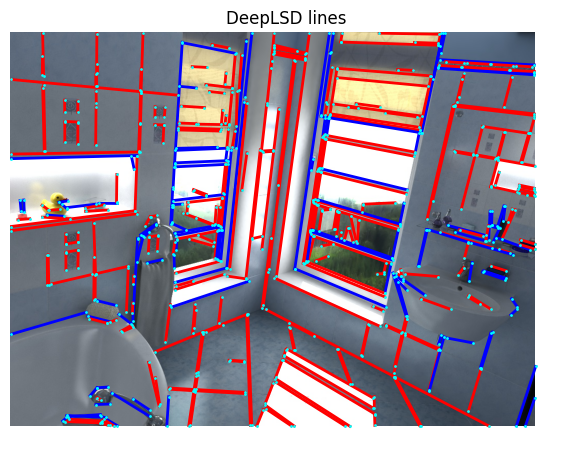

In [681]:
def plot_lines_struct(lines, structural_lines, point_color='cyan',
               ps=4, lw=2, indices=(0, 1), alpha=1):
  
    line_colors = ['blue' if struct else 'red' for struct in structural_lines]


    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 0, 0], l[i, 1, 0]), (l[i, 0, 1], l[i, 1, 1]),
                zorder=1, c=line_colors[i], linewidth=lw, alpha=alpha)
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 0], pts[:, 1], c=point_color, s=ps,
                  linewidths=0, zorder=2, alpha=alpha)
# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines_struct([pred_lines], structural_lines, indices=range(1))


# Find coplanar lines

In [781]:


def is_coplanar(x1, y1, x2, y2, x3, y3, x4, y4, depth_map, normal_map):
    #depth_values, normal_values = extract_line_data(x1 - 1, y1-1, x2+1, y2+1, depth_map, normal_map)
    depth_values1, normal_values1 = extract_line_data(x1, y1, x2, y2, depth_map, normal_map)
    depth_values2, normal_values2 = extract_line_data(x3, y3, x4, y4, depth_map, normal_map)
    h, w = depth_map.shape

    # Ensure valid pixel coordinates
    x1 = np.clip(x1, 0, w - 1)
    y1 = np.clip(y1, 0, h - 1)

    x2 = np.clip(x2, 0, w - 1)
    y2 = np.clip(y2, 0, h - 1)
    x3 = np.clip(x3, 0, w - 1)
    y3 = np.clip(y3, 0, h - 1)
    x4 = np.clip(x4, 0, w - 1)
    y4 = np.clip(y4, 0, h - 1)




    midpoint1 = ((x1 + x2) // 2, (y1 + y2) // 2)  # Midpoint
    midpoint2 = ((x3 + x4) // 2, (y3 + y4) // 2)  # Midpoint

    normalmean1 = np.mean(normal_values1, axis=0)
    normalmean2 = np.mean(normal_values2, axis=0)
    normalmean1 /= np.linalg.norm(normalmean1)
    normalmean2 /= np.linalg.norm(normalmean2)

    # Compute depth discontinuity
    normal_dot_mid = (np.dot(normal_map[int(midpoint1[1]), int(midpoint1[0])], normal_map[int(midpoint2[1]), int(midpoint2[0])]))
    normal_dot_start = np.dot(normal_map[(int(y1)),int(x1)], normal_map[int(y3),int(x3)])
    normal_dot_end = np.dot(normal_map[int(y2),int(x2)], normal_map[int(y4),int(x4)])
    normal_dot = np.dot(normalmean1, normalmean2)
    normal_threshold = 0.99
    return (normal_dot > normal_threshold) and normal_dot_mid > normal_threshold


coplanars = [False] * len(pred_lines)
coplanar_dict = []
for i in range(len(pred_lines)):
    coplanar_dict.append([False] * len(pred_lines))
    



for i in range(len(pred_lines)):
    for j in range(len(pred_lines)):
        if i != j:
            line1 = pred_lines[i]
            line2 = pred_lines[j]
            if is_coplanar(line1[0,0], line1[0,1], line1[1,0], line1[1,1], line2[0,0], line2[0,1], line2[1,0], line2[1,1], depth_map, normal_map):
                coplanars[i] = True
                coplanars[j] = True
                coplanar_dict[i][j] = True

            



In [779]:
print(coplanars)
print(coplanar_dict[0])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, 

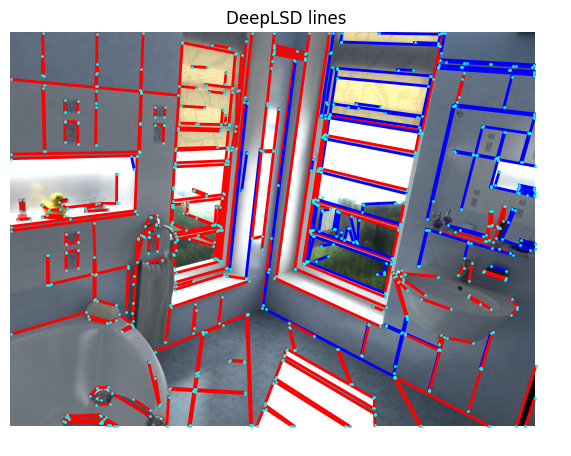

In [782]:

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines_struct([pred_lines], coplanar_dict[29], indices=range(1))